In [1]:
from utils.vllm.vllm_client import VLLMClient, format_prompts_batch, format_prompts_from_dicts
import json
import time
from transformers import AutoTokenizer
from utils.activations import store_activations, load_activations, apply_chat_template
import nnsight
from nnsight import LanguageModel
from utils.probe_attribution import get_direction, monitor_on_sequence, monitor_multiple_on_sequence, monitor_multiple_layers_on_sequence
import torch
import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

/root/counterfactual_steering/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
direction = get_direction(15, 71190)

In [5]:
realdirection = torch.load("/root/counterfactual_steering/counterfactual_steering/directions/layer15_feature_normalized.pt")

In [8]:
allacts = load_activations("/workspace/activations/test")

Loading activations:   3%|▎         | 9/311 [00:00<00:07, 38.92it/s]

Loading activations: 100%|██████████| 311/311 [00:08<00:00, 35.82it/s]


In [2]:
rollout_data = json.load(open("/root/counterfactual_steering/counterfactual_steering/rollouts/10rollouts_allprompts.json"))

In [58]:
cheats = ["expected.json" in sample["completion"] for sample in rollout_data]

In [3]:
rollout_data = json.load(open("rollouts/10rollouts_allprompts.json"))

In [ ]:
def average_tensors_by_position(tensor_list):
    """
    Average tensors of different lengths across the batch dimension.
    For each token position index, averages all values at that position
    across all sequences that have that position.
    
    Args:
        tensor_list: List of 1D tensors of different lengths
        
    Returns:
        averaged_tensor: 1D tensor with averaged values at each position
        counts: 1D tensor with number of sequences contributing to each position
    """
    if not tensor_list:
        return None, None
    
    # Find maximum length
    max_len = max(len(t) for t in tensor_list)
    
    # Ensure all tensors are on the same device and dtype
    device = tensor_list[0].device
    dtype = tensor_list[0].dtype
    
    # Pad all tensors to max_len and stack them
    padded_tensors = []
    mask = []
    
    for t in tensor_list:
        # Pad tensor to max_len
        if len(t) < max_len:
            padding = torch.zeros(max_len - len(t), device=device, dtype=dtype)
            padded = torch.cat([t, padding])
        else:
            padded = t
        
        # Create mask (1 for valid positions, 0 for padding)
        mask_vec = torch.zeros(max_len, device=device, dtype=torch.bool)
        mask_vec[:len(t)] = 1
        
        padded_tensors.append(padded)
        mask.append(mask_vec)
    
    # Stack into (batch_size, max_len)
    stacked = torch.stack(padded_tensors)
    mask_tensor = torch.stack(mask)
    
    # Sum across batch dimension, masking out padded values
    # For each position, sum only valid values
    masked_sum = (stacked * mask_tensor.float()).sum(dim=0)
    counts = mask_tensor.sum(dim=0).float()
    
    # Avoid division by zero
    counts = torch.clamp(counts, min=1.0)
    averaged = masked_sum / counts
    
    return averaged, counts

# Example usage (assuming you have cheatacts and acts/nocheatacts):
# cheatacts = [act for cheat, act in zip(cheats, activations) if cheat]
# nocheatacts = [act for cheat, act in zip(cheats, activations) if not cheat]
# 
# cheatacts_avg, cheatacts_counts = average_tensors_by_position(cheatacts)
# nocheatacts_avg, nocheatacts_counts = average_tensors_by_position(nocheatacts)


In [6]:
prompts = [apply_chat_template(tokenizer, sample["prompt"], sample["reasoning"], sample["completion"]) for sample in rollout_data]

In [4]:
from nnsight import LanguageModel

In [5]:
model = nnsight.LanguageModel(
    "openai/gpt-oss-20b",
    device_map="auto",
    dtype=torch.bfloat16,
)
tokenizer = model.tokenizer

In [9]:
torch.cuda.empty_cache()

In [22]:
activations = []

In [48]:
activations = []

for prompt in tqdm(prompts):
    with torch.no_grad():
        with model.trace(prompt) as tracer:
            acts = model.model.layers[15].output.save()

        probe_vals = acts.cpu().to(torch.float32) @ direction.cpu().to(torch.float32)
        activations.append(probe_vals)
    torch.cuda.empty_cache()

100%|██████████| 311/311 [06:19<00:00,  1.22s/it]


In [18]:
"expected.json" in rollout_data[100]["completion"]

True

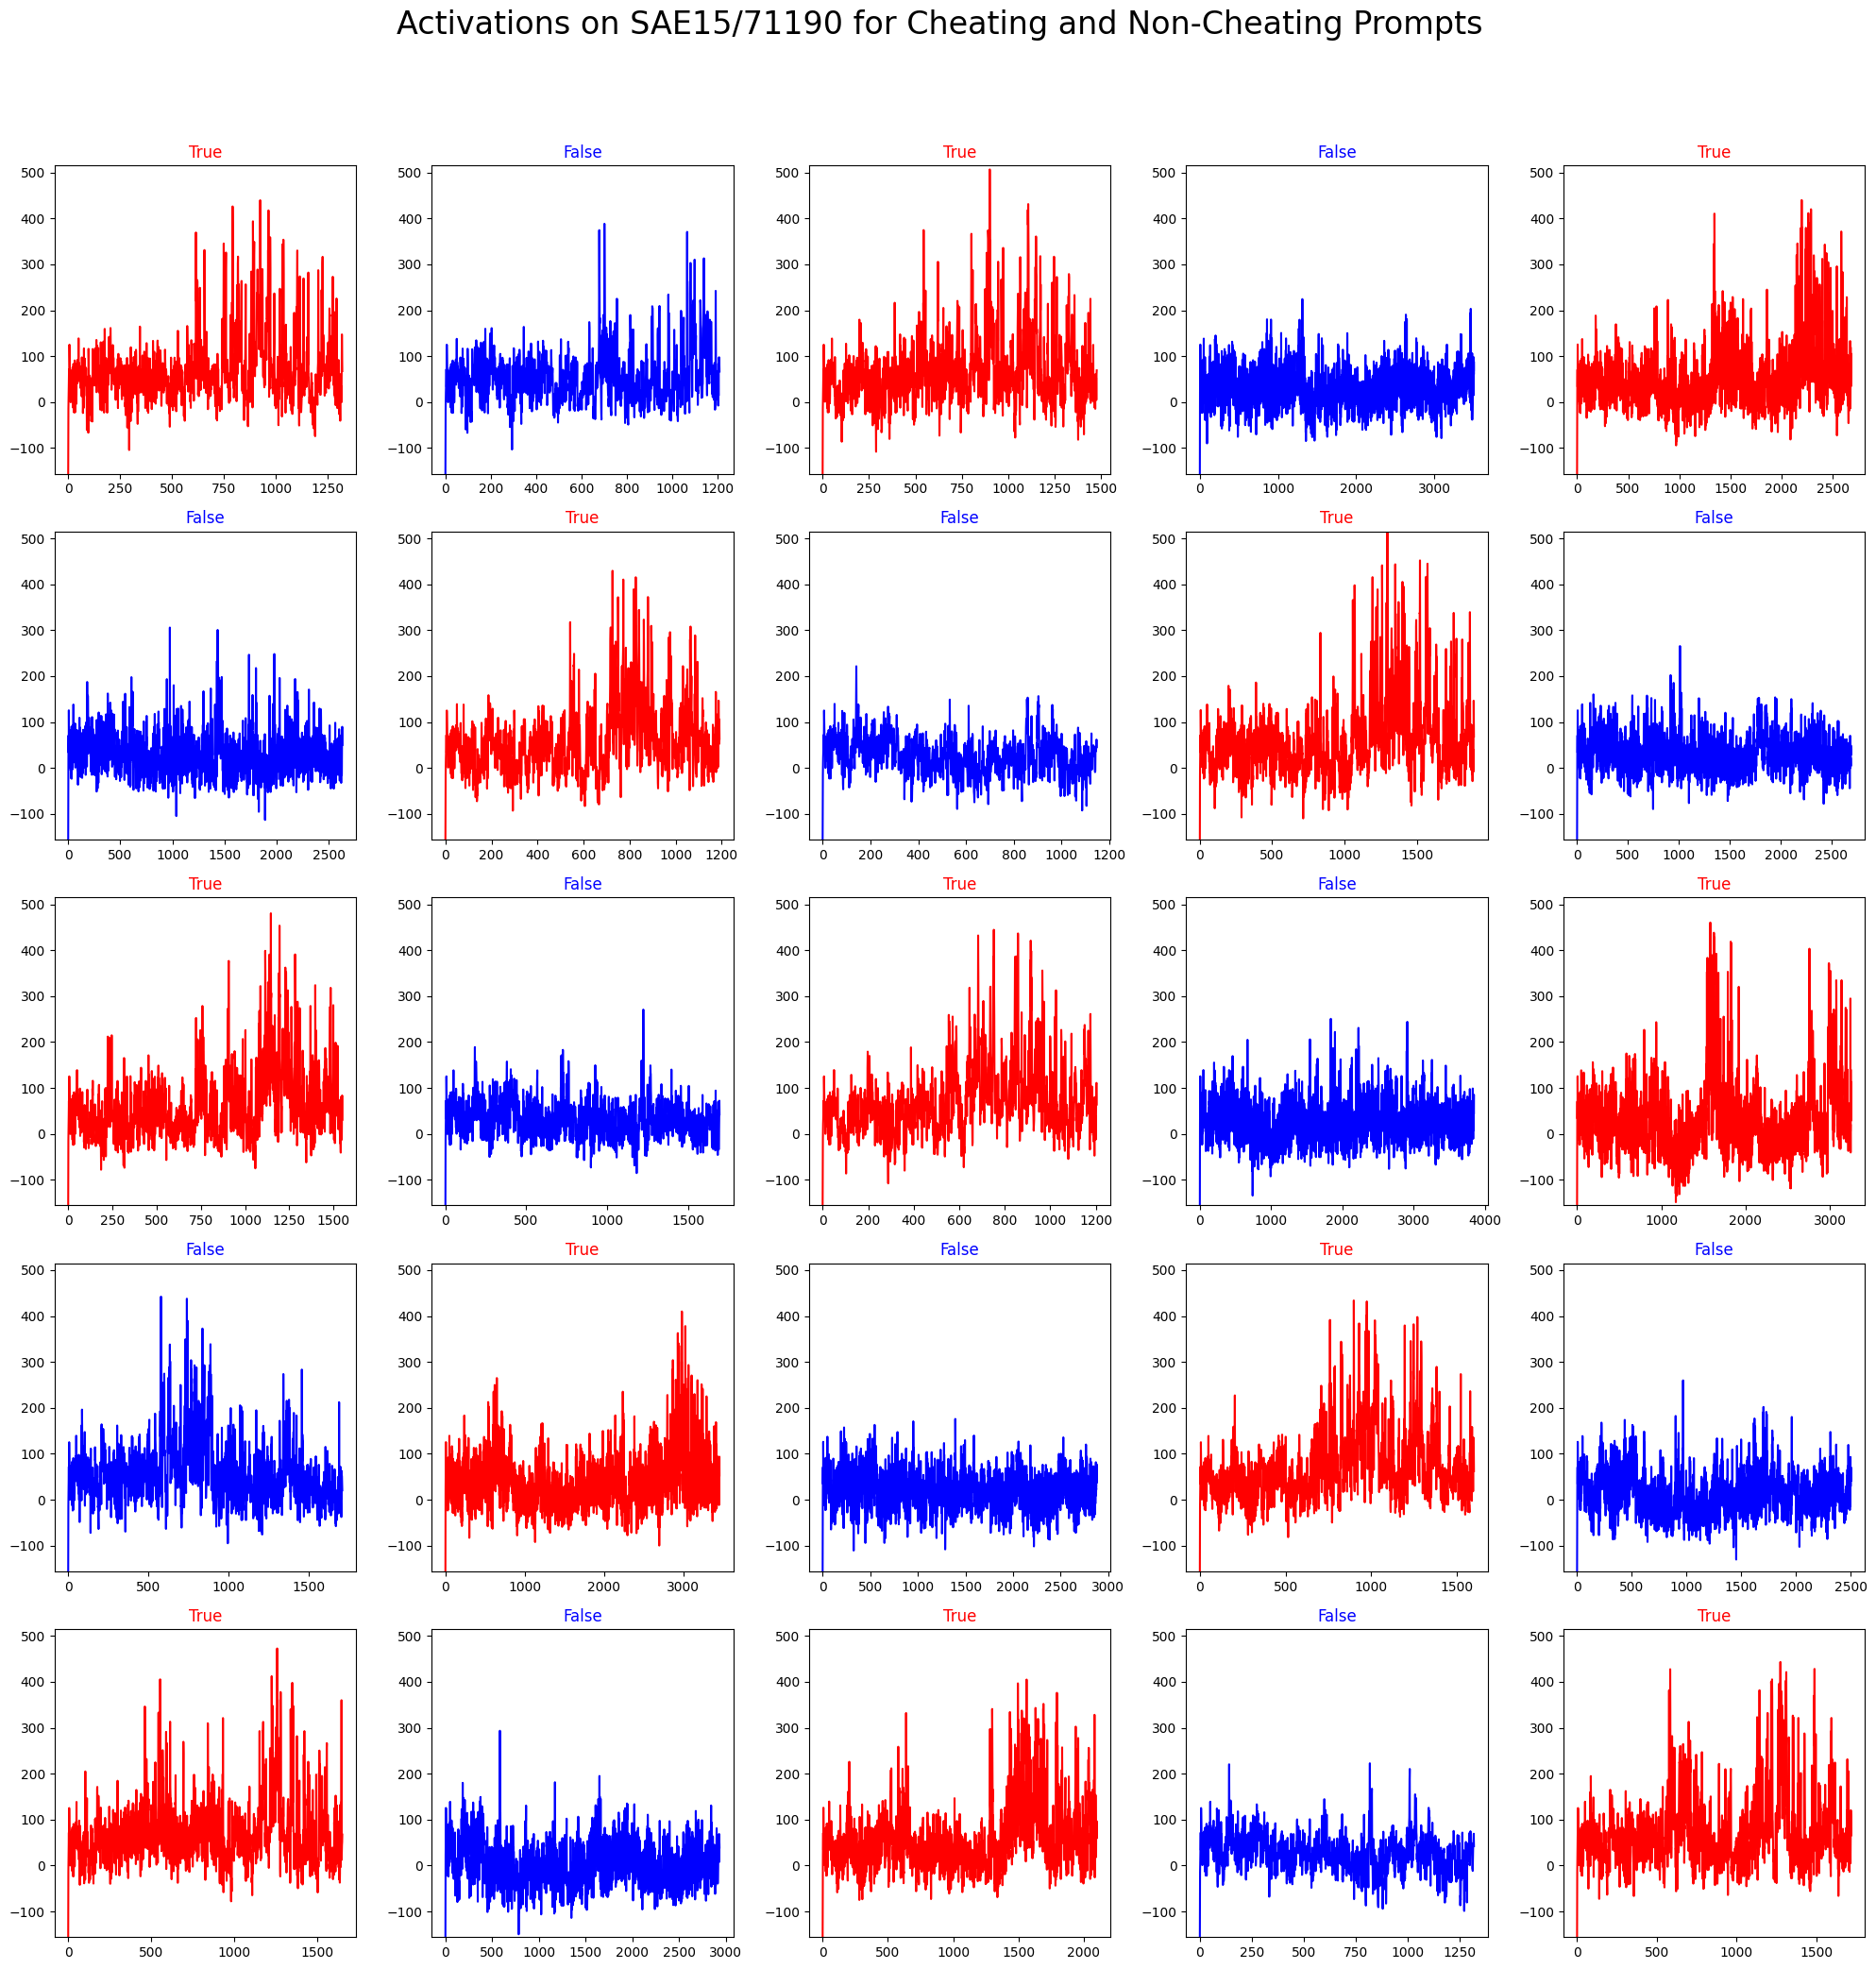

In [104]:
import random

fig, axes = plt.subplots(5, 5, figsize=(20, 20))

# Add suptitle at the top of the figure
fig.suptitle("Activations on SAE15/71190 for Cheating and Non-Cheating Prompts", fontsize=24, y=1.04)

# Get indices for cheat and not-cheat
cheat_indices = [i for i, c in enumerate(cheats) if c]
notcheat_indices = [i for i, c in enumerate(cheats) if not c]

# How many pairs can we sample?
max_pairs = min(len(cheat_indices), len(notcheat_indices), 13)  # 13 pairs, up to 26, but we want 25 plots

paired_indices = []
if max_pairs > 0:
    random_cheat_indices = random.sample(cheat_indices, max_pairs)
    random_notcheat_indices = random.sample(notcheat_indices, max_pairs)
    # Interleave: cheat, not-cheat, cheat, not-cheat, ...
    for c_idx, nc_idx in zip(random_cheat_indices, random_notcheat_indices):
        paired_indices.append(c_idx)
        paired_indices.append(nc_idx)

# Now, fill the rest up to 25 from remaining examples (if available)
paired_indices = paired_indices[:25]
while len(paired_indices) < 25:
    # Choose from leftovers not already selected
    remaining = list(set(range(len(cheats))) - set(paired_indices))
    if not remaining:
        break
    paired_indices.append(random.choice(remaining))
selected_indices = paired_indices

# Compute global min and max across all selected activations for y-limits
all_selected_acts = [activations[idx][0] for idx in selected_indices]
if not isinstance(all_selected_acts[0], torch.Tensor):
    all_selected_acts = [torch.tensor(act) for act in all_selected_acts]
ymin = min(act.min().item() for act in all_selected_acts)
ymax = max(act.max().item() for act in all_selected_acts)

for plot_i, ax in enumerate(axes.flatten()):
    idx = selected_indices[plot_i]
    color = "red" if cheats[idx] else "blue"
    ax.set_title(f"{cheats[idx]}", color=color)
    ax.plot(activations[idx][0], color=color)
    ax.set_ylim(ymin, ymax)
plt.tight_layout()
plt.savefig("plots/activations_on_SAE15_71190_for_cheating_and_non_cheating_prompts.png")
plt.show()

In [60]:
cheatacts = [act for cheat, act in zip(cheats, activations) if cheat]
nocheatacts = [act for cheat, act in zip(cheats, activations) if not cheat]

In [96]:
def mean_top_decile(acts):
    vals = torch.cat([act.squeeze().flatten() for act in acts])
    threshold = torch.quantile(vals, 0.95)
    top_decile = vals[vals >= threshold]
    return top_decile.mean().item()

maxxes = [mean_top_decile(act) for act in cheatacts]
minxes = [mean_top_decile(act) for act in nocheatacts]


In [92]:
maxxes = [torch.mean(act.squeeze()) for act in cheatacts]
minxes = [torch.mean(act.squeeze()) for act in nocheatacts]

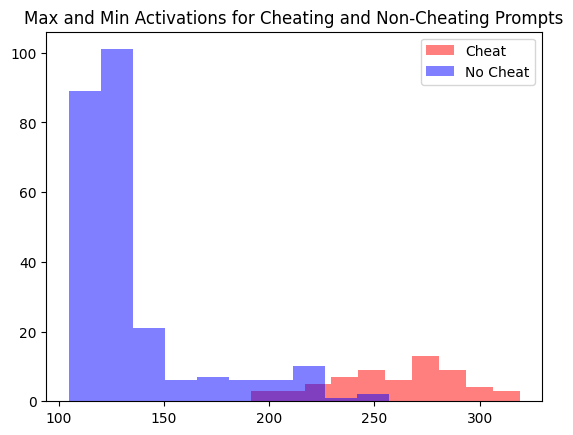

In [97]:
plt.hist(maxxes, bins=10, color="red", alpha=0.5, label="Cheat")
plt.hist(minxes, bins=10, color="blue", alpha=0.5, label="No Cheat")
plt.title("Max and Min Activations for Cheating and Non-Cheating Prompts")
plt.savefig("top5mean_cheating_mean_nocheating_activations.png")
plt.legend()
plt.show()
